In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from Scrapping.chrome import ChromeManager
from Twitter import TwitterScrapper
from datetime import datetime, datetime, timedelta
import time

In [2]:
corona_ratio_data = '..\\sentiment\\corona_lb_ratios.csv'

pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
df = pd.read_csv(corona_ratio_data, header=0)
df.head()

,date,year,month,day,new_cases,new_deaths,prev_cases,prev_deaths,total_cases,total_deaths,sentiment_ratio1,sentiment_ratio2,sentiment_ratio3,sentiment_ratio4
0,2/1/2020,2020,2,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,2/2/2020,2020,2,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2/3/2020,2020,2,3,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,2/4/2020,2020,2,4,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,2/5/2020,2020,2,5,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [4]:
x = df.month.map(str) + '_' + df.day.map(str)
y = df.sentiment_ratio3

zero = [0 for _ in range(len(x))]

mean_value = df.sentiment_ratio3.mean()
median = [mean_value for _ in range(len(x))]

max_value = df.sentiment_ratio3.max()
maximum = [max_value for _ in range(len(x))]

min_value = df.sentiment_ratio3.min()
minimum = [min_value for _ in range(len(x))]

std_value = df.sentiment_ratio3.std()
pos_std = [std_value for _ in range(len(x))]
neg_std = [-std_value for _ in range(len(x))]

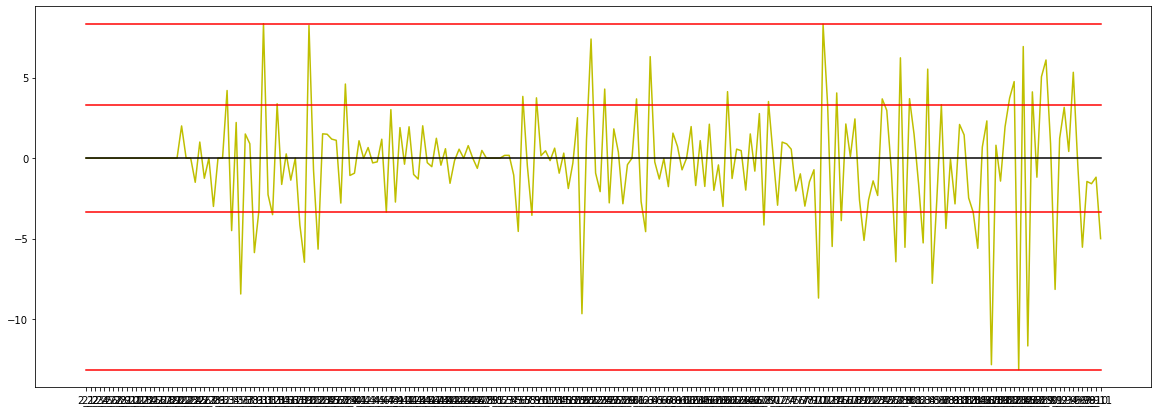

In [5]:
plt.figure(figsize=(20, 7))

plt.plot(
    x, y, 'y', 
    x, zero, 'black', 
#     x, median, 'b', 
    x, maximum, 'r', 
    x, minimum, 'r', 
    x, pos_std, 'r',
    x, neg_std, 'r'
)

In [6]:
hotspots_data = []
hotspots = []

for index, row in df.iterrows():
    # i choose to get the negative hotspots only for now
    # for positive & negative hotspots: (row.ratio_sentiment3 >= std_value() or (row.ratio_sentiment3 <= -std_value)
    if row.sentiment_ratio3 <= -std_value:
        hotspots_data.append(row.date)
        hotspots.append(row.sentiment_ratio3)
        
    else:
        hotspots.append(0)
        
    
print(len(hotspots_data), 'negative hotspots')
print(len(hotspots), 'spots')

30 negative hotspots
224 spots


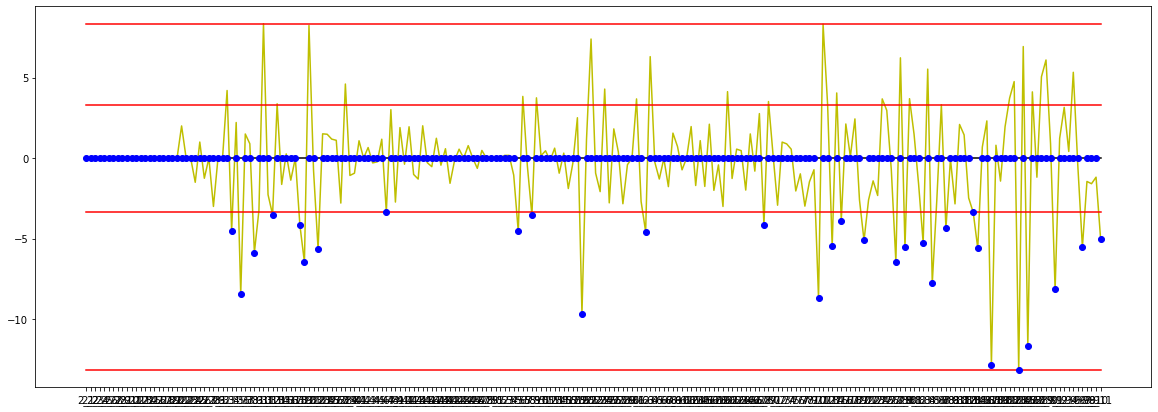

In [7]:
plt.figure(figsize=(20, 7))
plt.plot(
    x, y, 'y', 
    x, zero, 'black',
    x, maximum, 'r', 
    x, minimum, 'r', 
    x, pos_std, 'r',
    x, neg_std, 'r',
    x, hotspots, 'bo'
)

In [29]:
numeric = re.compile(r'\w*\d+\w*')
def accepted_word(w):
    return len(w) > 2 and re.search(numeric, w) is None

#----------------------------------------------------------------------------------------------------

def tf_idf(data, max_features=1000, ngram=(1, 1)):
    
    stopwords = list(map(lambda t: " ".join([w for w in t.split() if not accepted_word(w)]), data))
    print('Stopwords:', len(stopwords))
    
    tf_Idf = TfidfVectorizer(stop_words=stopwords, max_features=max_features, ngram_range=ngram)
    tf_Idf_fit = tf_Idf.fit_transform(data)
    feature_names = tf_Idf.get_feature_names()
    
    dense = tf_Idf_fit.todense()
    denselist = dense.tolist()

    tf_idf_table = pd.DataFrame(denselist, columns=feature_names)

    tf_idf_result = pd.DataFrame()
    tf_idf_result[['topic', 'score']] = tf_idf_table.mean().reset_index()
    tf_idf_result = tf_idf_result.sort_values('score', ascending=False).reset_index(drop=True)
    return tf_idf_result

#----------------------------------------------------------------------------------------------------

def get_tweets(since, until):
    cm = ChromeManager(headless=True)
    tw = TwitterScrapper(cm)
    tw.load_page(f'https://twitter.com/search?vertical=trends&q=until%3A{until}%20since%3A{since}&src=typed_query&lf=on')

    time.sleep(2)
    try:
        tw.get_all_tweets()

    except Exception as e:
        print(e)
        print(f'[Error] => got {len(tw.tweets)} tweets')
    
    finally:
        cm.close()

    tweets, tags = [], []
    for tweet in tw.tweets.values():
        tweets.append(tweet['text'])
        tags.append(tweet['tags'])
        
    return tweets, tags

#----------------------------------------------------------------------------------------------------

def get_hotspot_topics(since, until):
    tweets, tags = get_tweets(since, until)
    tags = [tag for tag_list in tags for tag in tag_list if tag]
    
    topics = tf_idf(tweets, ngram=(2, 3))
    topics = topics.loc[:50]
    print('[Since]:', since)
    print('[Until]:', until)
    print('[Topics]:', list(topics.topic))
    print('[Tags]:', tags)
    print('------------------------------------------')

In [30]:
since = datetime.strptime(hotspots_data[0], '%d/%m/%Y')
until = since + timedelta(days=1)

since = since.strftime('%Y-%m-%d')
until = until.strftime('%Y-%m-%d')

print(since)
print(until)

2020-04-03
2020-04-04


In [31]:
get_hotspot_topics(since, until)

[INFO] Driver loaded!
[INFO] Page loaded!
Running External Code...
[INFO] Tweets = 6
Running External Code...
[INFO] Tweets = 19
Running External Code...
[INFO] Tweets = 32
Running External Code...
[INFO] Tweets = 45
Running External Code...
[INFO] Tweets = 62
Running External Code...
[INFO] Tweets = 68
[INFO] Tweets = 68
Stopwords: 68


d:\desktop\github\m2-project\twittervenv\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['02', '04', '12', '124409156', '124409156_370329197', '13', '19', '1jqg6v8vptvrm', '1w9rx2s0t3yyg', '20', '2011', '2019', '2020', '2020inoneword', '28', '2al', '370329197', '39000', '48', '57000', '7pm', '928134', '93', 'alikaraki91', 'am', 'an', 'as', 'at', 'be', 'bf', 'bfsharetwitter', 'buzzfeed', 'by', 'com', 'coronavirus', 'covid', 'covid19', 'covid19pandemic', 'covid2019', 'covid_19', 'dabe3', 'de', 'deaths', 'do', 'dynamic', 'el', 'eliasabinasr1', 'episode5', 'fi', 'fortune', 'friends', 'go', 'he', 'https', 'hv207nhiy', 'if', 'igshid', 'imtvfjtkb', 'instagram', 'it', 'itdyajeek', 'jadmerhi1', 'jenniferabidor', 'la', 'linasalameh1', 'ma7ada', 'me', 'medscape', 'my', 'or', 'quiz_result', 'rid', 'so', 'soc_tw_share', 'src', 'tb', 'tv', 'up', 'us', 'utm_campaign', 'utm_s

[Since]: 2020-04-03
[Until]: 2020-04-04
[Topics]: ['this country', 'life unfair', 'replying nkioumji', 'replying neshan', 'love helseinki', 'feel like', 'metal festival earth', 'metal festival', 'pass it help', 'pass it', 'replying jadmerhi1 and', 'replying jadmerhi1', 'you re', 'the first', 'taht shbeke', 'raymond karakington', 'karakington alikaraki91', 'raymond karakington alikaraki91', 'nothing really', 'nothing really matters', 'want cry bass', 'bass can', 'want cry', 'think fi', 'really matters', 'romantic him', 'aww how romantic', 'aww how', 'think fi dabe3', 'all the', 'like already bored', 'bored tomorrow', 'like already', 'let hope', 'the first explanation', 'let hope for', 'replying linasalameh1 eliasabinasr1', 'linasalameh1 eliasabinasr1', 'wanna get drunk', 'wanna get', 'just wanna get', 'replying linasalameh1', 'your apology دحشو', 'your apology', 'this your apology', 'this your', 'just wanna', 'linasalameh1 eliasabinasr1 and', 'at home', 'else matters', 'okay you re']
[T